# Project


## data cleaning

In [400]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
air_quality = fetch_ucirepo(id=360) 
  
# data (as pandas dataframes) 
X = air_quality.data.features 

# metadata 
print(air_quality.metadata) 
  
# variable information 
print(air_quality.variables) 


{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': {'ID': 420, 'type': 'NATIVE', 'title': 'On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario', 'authors': 

In [401]:
# Check the shape of the dataset
print(f"X shape {X.shape}")

print("\n--- Basic Information ---")
print(X.info())

X shape (9357, 15)

--- Basic Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB
None


In [402]:
X.head

<bound method NDFrame.head of            Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0     3/10/2004  18:00:00     2.6         1360       150      11.9   
1     3/10/2004  19:00:00     2.0         1292       112       9.4   
2     3/10/2004  20:00:00     2.2         1402        88       9.0   
3     3/10/2004  21:00:00     2.2         1376        80       9.2   
4     3/10/2004  22:00:00     1.6         1272        51       6.5   
...         ...       ...     ...          ...       ...       ...   
9352   4/4/2005  10:00:00     3.1         1314      -200      13.5   
9353   4/4/2005  11:00:00     2.4         1163      -200      11.4   
9354   4/4/2005  12:00:00     2.4         1142      -200      12.4   
9355   4/4/2005  13:00:00     2.1         1003      -200       9.5   
9356   4/4/2005  14:00:00     2.2         1071      -200      11.9   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
0              1046      166          1056      113         

In [403]:
# Extract all columns with GT in their names as the target values
y = X.filter(like='GT') 

In [404]:
print (X.shape)

(9357, 15)


In [405]:
print (y.shape)

(9357, 5)


In [406]:
import numpy as np

# Replace -200 with NaN in the ground truth (y)
y_replaced = y.replace(-200, np.nan)

# Fill missing GT values using the closest available data in time
y_filled = y_replaced.fillna(method='ffill').fillna(method='bfill')

# Check if there are any remaining missing values
missing_after = y_filled.isnull().sum()
print("Remaining missing values after filling:")
print(missing_after)

# Replace the original y with the filled version
y = y_filled

# Verify results
print("Original y shape:", y_replaced.shape)
print("Cleaned y shape:", y.shape)


Remaining missing values after filling:
CO(GT)      0
NMHC(GT)    0
C6H6(GT)    0
NOx(GT)     0
NO2(GT)     0
dtype: int64
Original y shape: (9357, 5)
Cleaned y shape: (9357, 5)


C:\Users\Jean\AppData\Local\Temp\ipykernel_30284\2341125263.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_filled = y_replaced.fillna(method='ffill').fillna(method='bfill')


In [407]:
# Remove all negative pollution values from y
mask_y = ~(y < 0).any(axis=1)  # Retain rows where no negative values exist in y

# Remove all negative pollution values and values below -50 for 'AH', 'T', and 'RH' in X
mask_X = ~(X.filter(like='PT08').lt(0).any(axis=1))  # Remove negative values in pollution columns
mask_X &= (X['AH'] >= -50) & (X['T'] >= -50) & (X['RH'] >= -50)  # Apply the condition for AH, T, and RH

# Combine masks
final_mask = mask_y & mask_X

# Apply the combined mask to X and y
X = X[final_mask]
y = y[final_mask]

# Check the shapes of the cleaned data
print(f"Original X shape: {X.shape}, Cleaned X shape: {X.shape}")
print(f"Original y shape: {y.shape}, Cleaned y shape: {y.shape}")

Original X shape: (8991, 15), Cleaned X shape: (8991, 15)
Original y shape: (8991, 5), Cleaned y shape: (8991, 5)


In [408]:
# Drop the target columns from the features
X_RNN = X.drop(columns=y.columns)

# Also drop non-relevant columns like "Date" and "Time"
X = X_RNN.drop(columns=['Date', 'Time'])

# Verify the result
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print("Features (X):")
print(X.head())
print("Targets (y):")
print(y.head())


Features shape: (8991, 8)
Target shape: (8991, 5)
Features (X):
   PT08.S1(CO)  PT08.S2(NMHC)  PT08.S3(NOx)  PT08.S4(NO2)  PT08.S5(O3)     T  \
0         1360           1046          1056          1692         1268  13.6   
1         1292            955          1174          1559          972  13.3   
2         1402            939          1140          1555         1074  11.9   
3         1376            948          1092          1584         1203  11.0   
4         1272            836          1205          1490         1110  11.2   

     RH      AH  
0  48.9  0.7578  
1  47.7  0.7255  
2  54.0  0.7502  
3  60.0  0.7867  
4  59.6  0.7888  
Targets (y):
   CO(GT)  NMHC(GT)  C6H6(GT)  NOx(GT)  NO2(GT)
0     2.6     150.0      11.9    166.0    113.0
1     2.0     112.0       9.4    103.0     92.0
2     2.2      88.0       9.0    131.0    114.0
3     2.2      80.0       9.2    172.0    122.0
4     1.6      51.0       6.5    131.0    116.0


In [409]:
X_RNN.head

<bound method NDFrame.head of            Date      Time  PT08.S1(CO)  PT08.S2(NMHC)  PT08.S3(NOx)  \
0     3/10/2004  18:00:00         1360           1046          1056   
1     3/10/2004  19:00:00         1292            955          1174   
2     3/10/2004  20:00:00         1402            939          1140   
3     3/10/2004  21:00:00         1376            948          1092   
4     3/10/2004  22:00:00         1272            836          1205   
...         ...       ...          ...            ...           ...   
9352   4/4/2005  10:00:00         1314           1101           539   
9353   4/4/2005  11:00:00         1163           1027           604   
9354   4/4/2005  12:00:00         1142           1063           603   
9355   4/4/2005  13:00:00         1003            961           702   
9356   4/4/2005  14:00:00         1071           1047           654   

      PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
0             1692         1268  13.6  48.9  0.7578  
1        

In [410]:
# Convert Date and Time columns to datetime with the correct format
X_RNN['Date'] = pd.to_datetime(X_RNN['Date'], format='%m/%d/%Y')  # Adjust format to match your data
X_RNN['Time'] = pd.to_datetime(X_RNN['Time'], format='%H:%M:%S').dt.time

# Extract useful features from Date and Time
X_RNN['Year'] = X_RNN['Date'].dt.year
X_RNN['Month'] = X_RNN['Date'].dt.month
X_RNN['Day'] = X_RNN['Date'].dt.day
X_RNN['DayOfWeek'] = X_RNN['Date'].dt.dayofweek  # Monday=0, Sunday=6
X_RNN['Hour'] = pd.to_datetime(X_RNN['Time'], format='%H:%M:%S').dt.hour

# Drop original Date and Time columns 
X_RNN = X_RNN.drop(columns=['Date', 'Time'])

# View processed data
print(X_RNN.head())


   PT08.S1(CO)  PT08.S2(NMHC)  PT08.S3(NOx)  PT08.S4(NO2)  PT08.S5(O3)     T  \
0         1360           1046          1056          1692         1268  13.6   
1         1292            955          1174          1559          972  13.3   
2         1402            939          1140          1555         1074  11.9   
3         1376            948          1092          1584         1203  11.0   
4         1272            836          1205          1490         1110  11.2   

     RH      AH  Year  Month  Day  DayOfWeek  Hour  
0  48.9  0.7578  2004      3   10          2    18  
1  47.7  0.7255  2004      3   10          2    19  
2  54.0  0.7502  2004      3   10          2    20  
3  60.0  0.7867  2004      3   10          2    21  
4  59.6  0.7888  2004      3   10          2    22  


### Scaling

In [411]:
# Add cyclical encoding for Hour and DayOfWeek
X_RNN['Hour_sin'] = np.sin(2 * np.pi * X_RNN['Hour'] / 24)
X_RNN['Hour_cos'] = np.cos(2 * np.pi * X_RNN['Hour'] / 24)
X_RNN['DayOfWeek_sin'] = np.sin(2 * np.pi * X_RNN['DayOfWeek'] / 7)
X_RNN['DayOfWeek_cos'] = np.cos(2 * np.pi * X_RNN['DayOfWeek'] / 7)

# Drop raw Hour and DayOfWeek if not needed
X_RNN = X_RNN.drop(columns=['Hour', 'DayOfWeek'])
print("After Cyclical Encoding:")
print(X_RNN)


After Cyclical Encoding:
      PT08.S1(CO)  PT08.S2(NMHC)  PT08.S3(NOx)  PT08.S4(NO2)  PT08.S5(O3)  \
0            1360           1046          1056          1692         1268   
1            1292            955          1174          1559          972   
2            1402            939          1140          1555         1074   
3            1376            948          1092          1584         1203   
4            1272            836          1205          1490         1110   
...           ...            ...           ...           ...          ...   
9352         1314           1101           539          1374         1729   
9353         1163           1027           604          1264         1269   
9354         1142           1063           603          1241         1092   
9355         1003            961           702          1041          770   
9356         1071           1047           654          1129          816   

         T    RH      AH  Year  Month  Day      Ho

In [412]:
from sklearn.preprocessing import StandardScaler

# Initialize scalers 
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale X and y 
X_scaled_RNN = scaler_X.fit_transform(X_RNN)
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)


In [413]:
X_scaled.shape

(8991, 8)

In [414]:
from sklearn.model_selection import train_test_split
X_train_RNN, X_test_RNN,y_train_RNN, y_test_RNN = train_test_split(X_scaled_RNN,y_scaled, test_size=0.2)

X_train, X_test,y_train, y_test = train_test_split(X_scaled,y_scaled, test_size=0.2)

In [415]:
# Debug shapes
print(f"Original X_train_RNN shape: {X_train_RNN.shape}")

# Set time_steps to fit the data
time_steps = 5  # Adjust as needed (must be ≤ feature count)
if X_train_RNN.shape[1] % time_steps != 0:
    raise ValueError(
        f"Number of features ({X_train_RNN.shape[1]}) must be divisible by time_steps ({time_steps})."
    )

n_features = X_train_RNN.shape[1] // time_steps

# Reshape for RNN
X_train_RNN = X_train_RNN.reshape(-1, time_steps, n_features)
X_test_RNN = X_test_RNN.reshape(-1, time_steps, n_features)

print(f"New X_train_RNN shape: {X_train_RNN.shape}")
print(f"New X_test_RNN shape: {X_test_RNN.shape}")


Original X_train_RNN shape: (7192, 15)
New X_train_RNN shape: (7192, 5, 3)
New X_test_RNN shape: (1799, 5, 3)


In [416]:
X_train.shape

(7192, 8)

In [417]:
y_train.shape

(7192, 5)

### data analysis

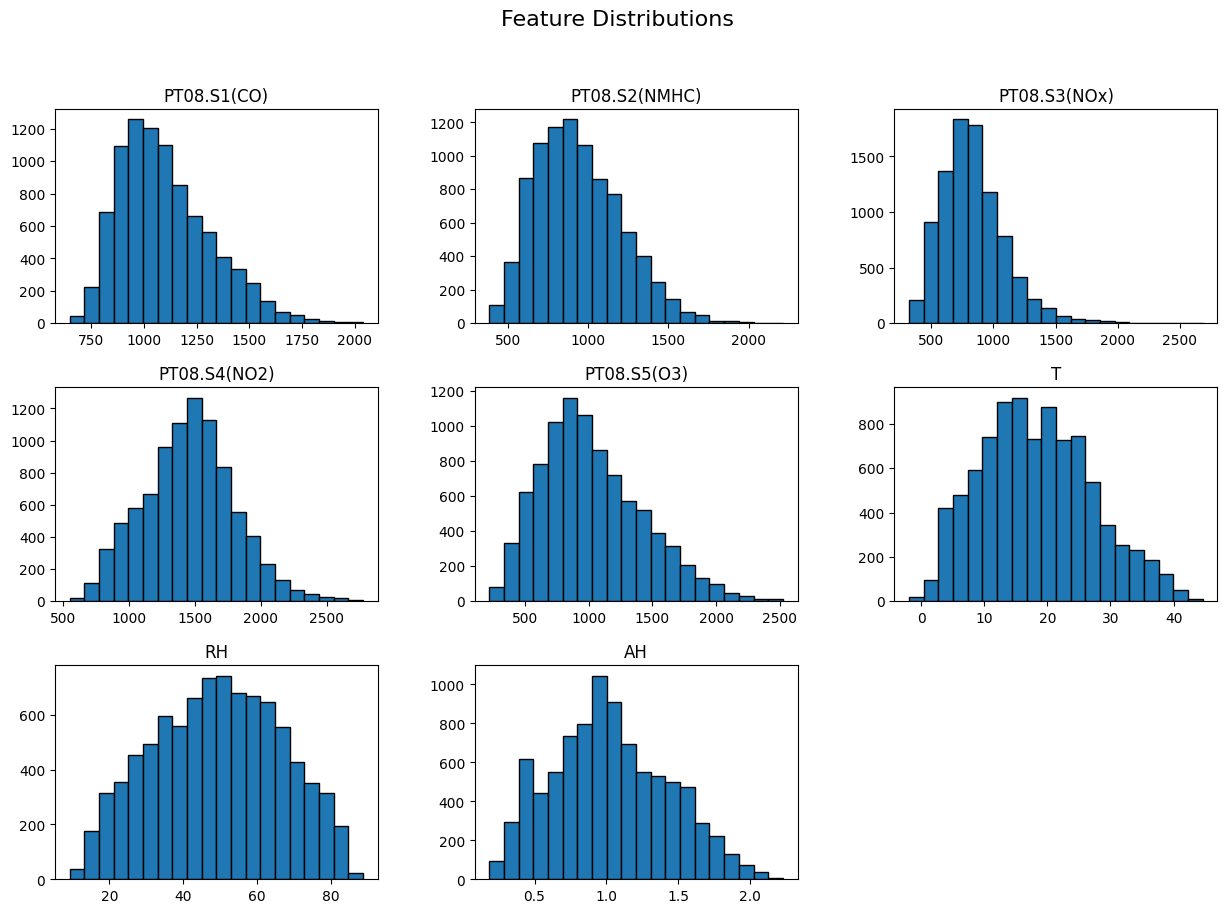

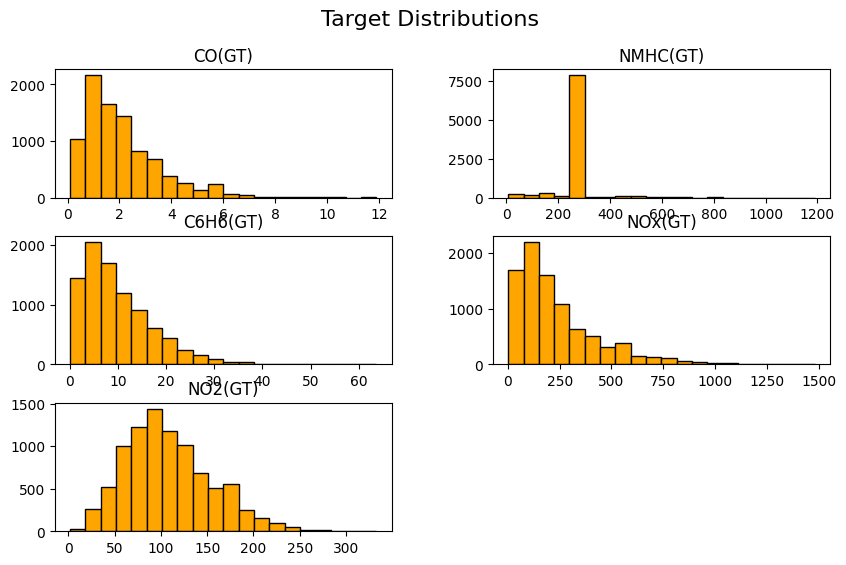

In [437]:
import matplotlib.pyplot as plt

# Plot histograms for features (X) and targets (y)
X.hist(figsize=(15, 10), bins=20, grid=False, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

y.hist(figsize=(10, 6), bins=20, grid=False, color='orange', edgecolor='black')
plt.suptitle("Target Distributions", fontsize=16)
plt.show()


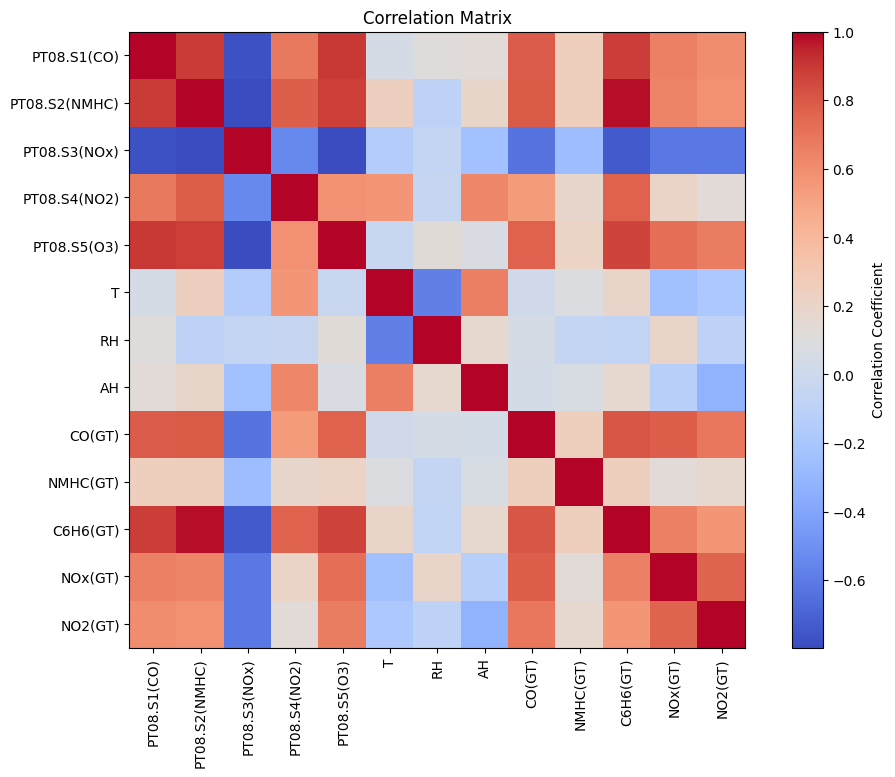

In [419]:
import pandas as pd

# Compute the correlation matrix
correlation_matrix = pd.concat([X, y], axis=1).corr()

# Visualize the correlation matrix using Matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label="Correlation Coefficient")
plt.title("Correlation Matrix")
plt.xticks(range(correlation_matrix.shape[0]), correlation_matrix.columns, rotation=90)
plt.yticks(range(correlation_matrix.shape[0]), correlation_matrix.index)
plt.show()


## Creating and training the model 


### I chose two models, a Deep Neural Network and a Recurrent Neural Network

In [420]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout


rnn = Sequential([
    SimpleRNN(64, activation='relu', input_shape=(5, 3)),  # (time_steps, features)
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(y_train_RNN.shape[1])  # Output shape matches your target
])


# Compile the model
rnn.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [421]:
history = rnn.fit(
    X_train_RNN, 
    y_train_RNN,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
180/180 [==============================] - 2s 4ms/step - loss: 0.6558 - mae: 0.5614 - val_loss: 0.4014 - val_mae: 0.3945
Epoch 2/50
180/180 [==============================] - 0s 3ms/step - loss: 0.4338 - mae: 0.4292 - val_loss: 0.3333 - val_mae: 0.3439
Epoch 3/50
180/180 [==============================] - 1s 3ms/step - loss: 0.3889 - mae: 0.4008 - val_loss: 0.3084 - val_mae: 0.3287
Epoch 4/50
180/180 [==============================] - 1s 3ms/step - loss: 0.3610 - mae: 0.3819 - val_loss: 0.3015 - val_mae: 0.3174
Epoch 5/50
180/180 [==============================] - 1s 3ms/step - loss: 0.3480 - mae: 0.3701 - val_loss: 0.2960 - val_mae: 0.3158
Epoch 6/50
180/180 [==============================] - 1s 3ms/step - loss: 0.3304 - mae: 0.3587 - val_loss: 0.2647 - val_mae: 0.2930
Epoch 7/50
180/180 [==============================] - 1s 4ms/step - loss: 0.3189 - mae: 0.3513 - val_loss: 0.2629 - val_mae: 0.2830
Epoch 8/50
180/180 [==============================] - 1s 3ms/step - loss: 0.

In [422]:
test_loss, test_mae = rnn.evaluate(X_test_RNN, y_test_RNN)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


57/57 [==============================] - 0s 2ms/step - loss: 0.1773 - mae: 0.2411
Test Loss: 0.17731918394565582, Test MAE: 0.24108090996742249


In [423]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
rnn_preds = rnn.predict(X_test_RNN)
rnn_mae = mean_absolute_error(y_test, rnn_preds)
rnn_mse = mean_squared_error(y_test, rnn_preds)
rnn_rmse = np.sqrt(rnn_mse)
rnn_r2 = r2_score(y_test, rnn_preds)

print(f"RNN - MAE: {rnn_mae}, MSE: {rnn_mse}, RMSE: {rnn_rmse}, R2: {rnn_r2}")

57/57 [==============================] - 0s 1ms/step
RNN - MAE: 0.9074878313123724, MSE: 1.7454900994829003, RMSE: 1.3211699737289295, R2: -0.6771776267414398


In [424]:
rnn.save("RNN_model.h5")
print("Model saved as RNN_model.h5")

Model saved as RNN_model.h5


c:\Users\Jean\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


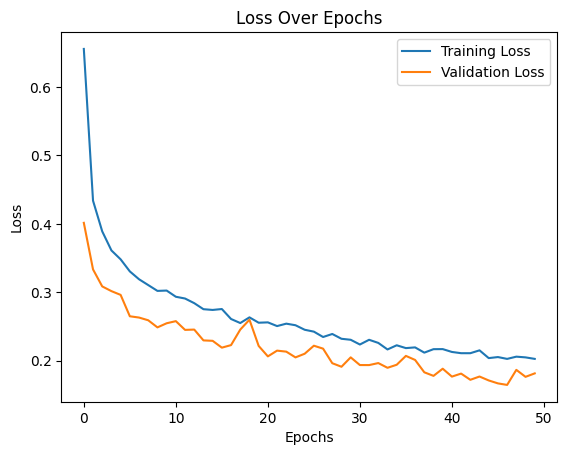

In [425]:
import matplotlib.pyplot as plt

# Example: Assuming `history` is the result of model.fit()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## DEEP NN

In [426]:
# Define the DNN model
dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    Dropout(0.3),  # Prevent overfitting
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.2),
    Dense(32, activation='relu'),  # Hidden layer
    Dense(y_train.shape[1], activation='linear')  # Output layer (regression task)
])

# Compile the model
dnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = dnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
180/180 [==============================] - 1s 3ms/step - loss: 0.4923 - mae: 0.4417 - val_loss: 0.3594 - val_mae: 0.3482
Epoch 2/50
180/180 [==============================] - 0s 3ms/step - loss: 0.3726 - mae: 0.3669 - val_loss: 0.3230 - val_mae: 0.3130
Epoch 3/50
180/180 [==============================] - 0s 2ms/step - loss: 0.3418 - mae: 0.3460 - val_loss: 0.3059 - val_mae: 0.3076
Epoch 4/50
180/180 [==============================] - 0s 3ms/step - loss: 0.3174 - mae: 0.3317 - val_loss: 0.2911 - val_mae: 0.2935
Epoch 5/50
180/180 [==============================] - 0s 3ms/step - loss: 0.3059 - mae: 0.3254 - val_loss: 0.2722 - val_mae: 0.2802
Epoch 6/50
180/180 [==============================] - 0s 2ms/step - loss: 0.2924 - mae: 0.3158 - val_loss: 0.2885 - val_mae: 0.2978
Epoch 7/50
180/180 [==============================] - 0s 3ms/step - loss: 0.2889 - mae: 0.3115 - val_loss: 0.2732 - val_mae: 0.2825
Epoch 8/50
180/180 [==============================] - 0s 2ms/step - loss: 0.

In [427]:
dnn.save("Deep_NN_model.h5")

57/57 [==============================] - 0s 1ms/step - loss: 0.2387 - mae: 0.2565
Test Loss: 0.23868109285831451, Test MAE: 0.25649726390838623


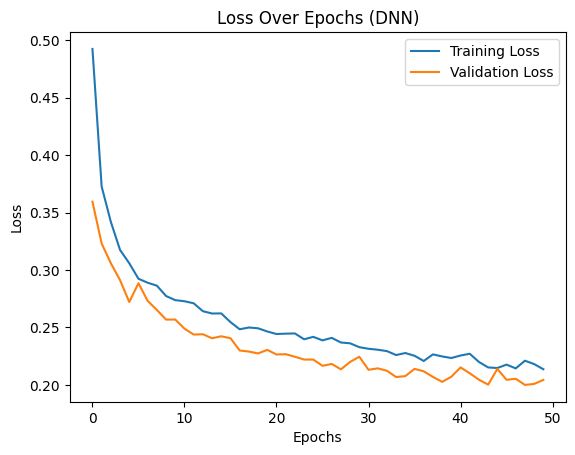

In [428]:
# Evaluate the model
test_loss, test_mae = dnn.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs (DNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [429]:
dnn_preds = dnn.predict(X_test)
dnn_mae = mean_absolute_error(y_test, dnn_preds)
dnn_mse = mean_squared_error(y_test, dnn_preds)
dnn_rmse = np.sqrt(dnn_mse)
dnn_r2 = r2_score(y_test, dnn_preds)

57/57 [==============================] - 0s 966us/step


## Improvement


To improve we will create a more complex model, and change hyperparameters

change rnn to lstm

In [432]:
from tensorflow.keras.layers import LSTM


model_rnn_improve = Sequential([
    LSTM(128, activation='relu', input_shape=(5, 3)),
    Dropout(0.2),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(32, activation = 'relu'),
    Dense(y_train.shape[1], activation='linear')
])

model_rnn_improve.compile(optimizer = 'Adam', loss = 'mse', metrics = 'mae')

history_improve_rnn = model_rnn_improve.fit(X_train_RNN, y_train_RNN, validation_split= 0.2, epochs = 50, batch_size = 32)



Epoch 1/50
180/180 [==============================] - 3s 8ms/step - loss: 0.6128 - mae: 0.5048 - val_loss: 0.4238 - val_mae: 0.4070
Epoch 2/50
180/180 [==============================] - 1s 7ms/step - loss: 0.4454 - mae: 0.4094 - val_loss: 0.3916 - val_mae: 0.3849
Epoch 3/50
180/180 [==============================] - 1s 7ms/step - loss: 0.4169 - mae: 0.3931 - val_loss: 0.4002 - val_mae: 0.3792
Epoch 4/50
180/180 [==============================] - 1s 7ms/step - loss: 0.3893 - mae: 0.3777 - val_loss: 0.3405 - val_mae: 0.3432
Epoch 5/50
180/180 [==============================] - 1s 7ms/step - loss: 0.3658 - mae: 0.3679 - val_loss: 0.3239 - val_mae: 0.3281
Epoch 6/50
180/180 [==============================] - 1s 7ms/step - loss: 0.3388 - mae: 0.3511 - val_loss: 0.3020 - val_mae: 0.3241
Epoch 7/50
180/180 [==============================] - 1s 7ms/step - loss: 0.3237 - mae: 0.3393 - val_loss: 0.2741 - val_mae: 0.2995
Epoch 8/50
180/180 [==============================] - 1s 7ms/step - loss: 0.

57/57 [==============================] - 0s 3ms/step - loss: 0.1732 - mae: 0.2454
Test Loss: 0.17317453026771545, Test MAE: 0.24542540311813354


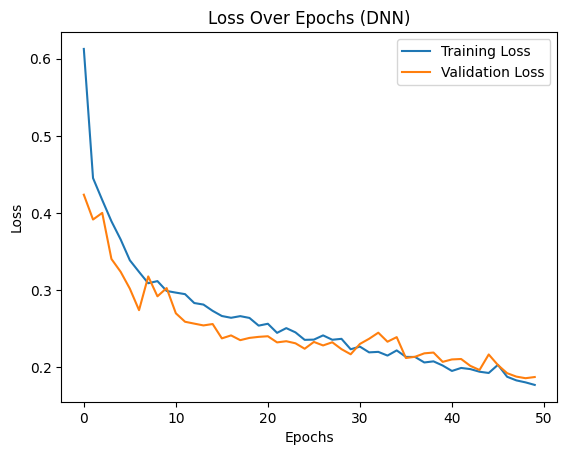

In [433]:
# Evaluate the model
test_loss, test_mae = model_rnn_improve.evaluate(X_test_RNN, y_test_RNN)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Plot the loss
plt.plot(history_improve_rnn.history['loss'], label='Training Loss')
plt.plot(history_improve_rnn.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs (DNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## change dnn to more complex

In [434]:
model_dnn_improve = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(64, activation = 'relu'),
    Dense(y_train.shape[1], activation = 'linear')
])

model_dnn_improve.compile(optimizer = 'Adam', loss= 'mse', metrics = 'mae')

history_improve_dnn = model_dnn_improve.fit(X_train, y_train, validation_split = 0.2, epochs = 50, batch_size = 32)


Epoch 1/50
180/180 [==============================] - 2s 4ms/step - loss: 0.4179 - mae: 0.4004 - val_loss: 0.3133 - val_mae: 0.3112
Epoch 2/50
180/180 [==============================] - 1s 3ms/step - loss: 0.3150 - mae: 0.3305 - val_loss: 0.2808 - val_mae: 0.2908
Epoch 3/50
180/180 [==============================] - 1s 3ms/step - loss: 0.2922 - mae: 0.3133 - val_loss: 0.2675 - val_mae: 0.2823
Epoch 4/50
180/180 [==============================] - 1s 3ms/step - loss: 0.2771 - mae: 0.3027 - val_loss: 0.2545 - val_mae: 0.2742
Epoch 5/50
180/180 [==============================] - 1s 3ms/step - loss: 0.2695 - mae: 0.2974 - val_loss: 0.2482 - val_mae: 0.2653
Epoch 6/50
180/180 [==============================] - 1s 3ms/step - loss: 0.2641 - mae: 0.2932 - val_loss: 0.2474 - val_mae: 0.2694
Epoch 7/50
180/180 [==============================] - 1s 3ms/step - loss: 0.2584 - mae: 0.2867 - val_loss: 0.2372 - val_mae: 0.2613
Epoch 8/50
180/180 [==============================] - 1s 3ms/step - loss: 0.

57/57 [==============================] - 0s 1ms/step - loss: 0.2086 - mae: 0.2344
Test Loss: 0.20856404304504395, Test MAE: 0.2343684285879135


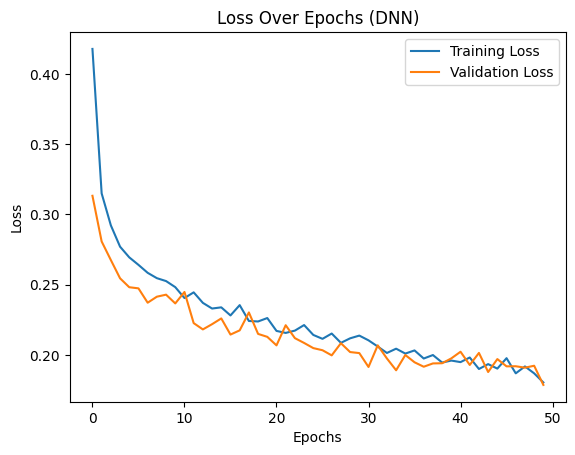

In [435]:
# Evaluate the model
test_loss, test_mae = model_dnn_improve.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Plot the loss
plt.plot(history_improve_dnn.history['loss'], label='Training Loss')
plt.plot(history_improve_dnn.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs (DNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()